In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import datetime
from tqdm import tqdm, trange
tqdm.pandas()

rides = pd.read_csv('../data/rideshare_kaggle.csv')
locations = {'Haymarket Square':0, 'Back Bay':1, 'North End':2,
             'North Station':3,'Beacon Hill':4, 'Boston University':5,
             'Fenway':6, 'South Station':7, 'Theatre District':8, 'West End':9,
             'Financial District':10, 'Northeastern University':11}

C:\Users\evanj\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
rides.columns

Index(['id', 'timestamp', 'hour', 'day', 'month', 'datetime', 'timezone',
       'source', 'destination', 'cab_type', 'product_id', 'name', 'price',
       'distance', 'surge_multiplier', 'latitude', 'longitude', 'temperature',
       'apparentTemperature', 'short_summary', 'long_summary',
       'precipIntensity', 'precipProbability', 'humidity', 'windSpeed',
       'windGust', 'windGustTime', 'visibility', 'temperatureHigh',
       'temperatureHighTime', 'temperatureLow', 'temperatureLowTime',
       'apparentTemperatureHigh', 'apparentTemperatureHighTime',
       'apparentTemperatureLow', 'apparentTemperatureLowTime', 'icon',
       'dewPoint', 'pressure', 'windBearing', 'cloudCover', 'uvIndex',
       'visibility.1', 'ozone', 'sunriseTime', 'sunsetTime', 'moonPhase',
       'precipIntensityMax', 'uvIndexTime', 'temperatureMin',
       'temperatureMinTime', 'temperatureMax', 'temperatureMaxTime',
       'apparentTemperatureMin', 'apparentTemperatureMinTime',
       'apparentTemperat

<AxesSubplot:>

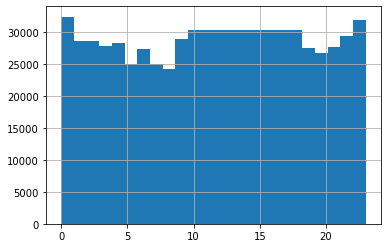

In [3]:
rides.hour.hist(bins=24)

In [4]:
rides['weekday'] = rides.progress_apply(lambda row: datetime.datetime.strptime(row['datetime'], '%Y-%m-%d %H:%M:%S').weekday(), axis=1)
rides['date'] = rides.progress_apply(lambda row: datetime.datetime.strptime(row['datetime'], '%Y-%m-%d %H:%M:%S').date(), axis=1)

100%|███████████████████████████████████████████████████████████████████████| 693071/693071 [00:19<00:00, 36232.91it/s]


<AxesSubplot:>

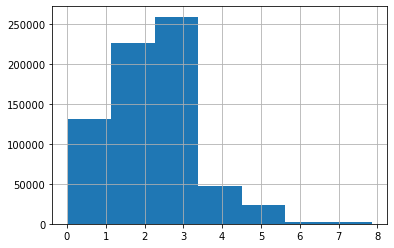

In [5]:
rides.distance.hist(bins=7)

In [6]:
sources = rides.source.to_numpy()
destinations = rides.destination.to_numpy()
ride_corr = np.zeros((len(locations),len(locations)))
for source in tqdm(list(locations.keys())):
    for destination in list(locations.keys()):
        source_idx = locations[source]
        destination_idx = locations[destination]
        ride_corr[source_idx,destination_idx] = len(np.intersect1d(np.where(sources==source),np.where(destinations==destination)))

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.27it/s]


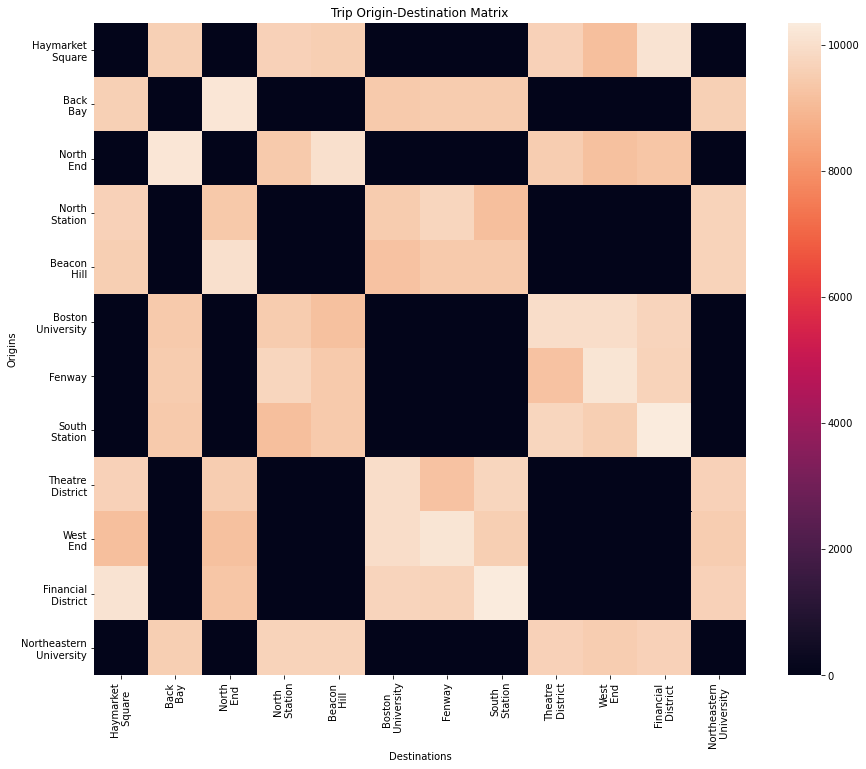

In [7]:
fig,ax = plt.subplots(figsize=(15,12))
ax = sns.heatmap(ride_corr, square=True)
ax.set_title('Trip Origin-Destination Matrix')
ax.set_ylabel('Origins')
labels = [s.replace(' ','\n ') for s in list(locations.keys())]
ax.set_yticklabels(labels, rotation='horizontal')
ax.set_xlabel('Destinations')
ax.set_xticklabels(labels, rotation='vertical')
plt.savefig('../figures/scooter_od_matrix.png',format='png')
plt.show()

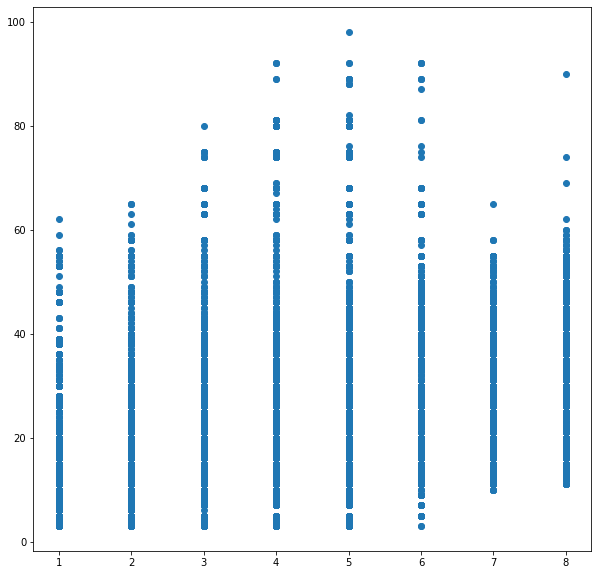

In [8]:
plt.figure(figsize=(10,10))
plt.scatter(np.ceil(rides['distance']),np.ceil(rides['price']))
plt.show()

In [10]:
rides.price

0          5.0
1         11.0
2          7.0
3         26.0
4          9.0
          ... 
693066    13.0
693067     9.5
693068     NaN
693069    27.0
693070    10.0
Name: price, Length: 693071, dtype: float64

<AxesSubplot:>

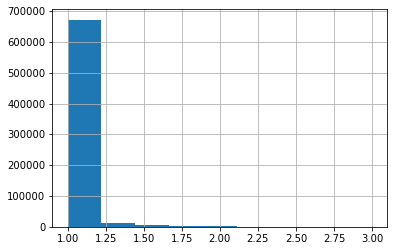

In [15]:
rides.surge_multiplier.hist(bins=9)

In [41]:
new_rides = rides.drop(['id','timestamp','datetime','long_summary','apparentTemperatureHighTime','apparentTemperatureLowTime',
                        'apparentTemperatureLowTime','windGustTime','sunriseTime','sunsetTime','uvIndexTime','temperatureMinTime',
                        'temperatureMaxTime','apparentTemperatureMinTime','temperatureLowTime','apparentTemperatureMaxTime',
                        'latitude','longitude','temperatureMin','timezone','month','source','destination','product_id',
                        'surge_multiplier','temperature','apparentTemperature','short_summary','precipProbability','humidity',
                        'windSpeed','windGust','visibility','temperatureHigh','temperatureHighTime','temperatureLow',
                        'apparentTemperatureHigh','apparentTemperatureLow','visibility.1','ozone','moonPhase','icon','dewPoint',
                        'pressure','windBearing','cloudCover','uvIndex','temperatureMin','temperatureMax','apparentTemperatureMin',
                        'apparentTemperatureMax','date','day','precipIntensityMax'],axis = 1)

from sklearn.preprocessing import OneHotEncoder
cat_col = ['cab_type','name','weekday']

#intiate OneHotEncoder and concatinating original df with encoded column df's
for col in cat_col:
    encoder = OneHotEncoder(handle_unknown='ignore')
    enc_df = pd.DataFrame(encoder.fit_transform(new_rides[[col]]).toarray())
    enc_df.columns = encoder.get_feature_names([col])
    new_rides = new_rides.drop(col, axis=1)
    new_rides = pd.concat([new_rides, enc_df], axis=1)
    
new_rides = new_rides.dropna(subset = ['price']).reset_index()

In [48]:
new_rides.columns

Index(['index', 'hour', 'price', 'distance', 'precipIntensity',
       'cab_type_Lyft', 'cab_type_Uber', 'name_Black', 'name_Black SUV',
       'name_Lux', 'name_Lux Black', 'name_Lux Black XL', 'name_Lyft',
       'name_Lyft XL', 'name_Shared', 'name_Taxi', 'name_UberPool',
       'name_UberX', 'name_UberXL', 'name_WAV', 'weekday_0', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6'],
      dtype='object')

In [47]:
from sklearn.model_selection import train_test_split
y = new_rides['price'].values
X = new_rides.drop(columns=['price'],axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
model = lin_reg.fit(X_train,y_train)
y_pred=model.predict(X_test)

model.coef_

array([-1.29212894e-08, -2.47819116e-04,  2.83971561e+00, -1.45456750e-01,
        6.73257458e-01, -6.73257458e-01,  4.61913027e+00,  1.43789771e+01,
        5.23894836e-01,  5.81472640e+00,  1.51370289e+01, -7.63514673e+00,
       -1.94590816e+00, -1.12213378e+01,  0.00000000e+00, -7.15185254e+00,
       -6.14331883e+00, -2.27056619e-01, -6.14913678e+00,  1.38455360e-03,
        8.02888735e-03,  1.85015531e-04,  8.45946896e-03, -7.02646264e-03,
        3.72683021e-03, -1.47582930e-02])